In [1]:
import torch
from transformers import SamModel, SamProcessor
import os
import json
import numpy as np
from PIL import Image
from datasets import Dataset
from pycocotools.coco import COCO

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

c:\Users\al3xz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def pad_bboxes(bboxes_list, max_boxes):
	padded_bboxes = []
	
	for bboxes in bboxes_list:
		num_padding = max_boxes - len(bboxes)
		if num_padding > 0:
			padded_bboxes.append(torch.cat([bboxes, torch.zeros(num_padding, 4)]))
		else:
			padded_bboxes.append(bboxes)
	return padded_bboxes


def load_coco_dataset(image_folder, annotation_file, mask_folder):
	# Lade die Annotationsdatei
	with open(annotation_file, 'r') as f:
		coco_annotations = json.load(f)

	coco = COCO(annotation_file)

	# Erstelle eine Liste von Bilddaten
	image_data = []
	for img_id in coco.imgs:
		img_info = coco.imgs[img_id]
		img_path = os.path.join(image_folder, img_info['file_name'])
	
		# Lade Bild als Numpy-Array
		img = Image.open(img_path).convert('RGB')
		
		# Lade die zugehörigen Masken (hier gehen wir davon aus, dass die Masken als PNG gespeichert sind)
		mask_path = os.path.join(mask_folder, f"mask_{img_info['file_name'].replace('.jpg', '.png')}")
		
		annotations = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
		
		# Extrahiere Bounding Boxes und Masken
		bboxes = []
		masks = []
		for ann in annotations:
			bbox = ann['bbox']  # [x, y, width, height]
			bboxes.append(bbox)
			
			# Lade die Maske (als PNG Bild)
			mask = np.array(Image.open(mask_path).convert('1'))  # Umwandlung in binär (0 oder 255)
			mask = mask.astype(np.uint8)
			masks.append(mask)
	
		image_data.append({
			'image': img,
			'bboxes': bboxes,
			'masks': masks
		})

	return image_data

# Konvertiere die Bilddaten in das Dataset-Format von Hugging Face
def create_huggingface_dataset(image_folder, annotation_file, mask_folder):
	image_data = load_coco_dataset(image_folder, annotation_file, mask_folder)
  
	bboxes_list = [torch.tensor(data["bboxes"]) for data in image_data]
 
	max_boxes = max([len(bboxes) for bboxes in bboxes_list])
 
	padded_bboxes = pad_bboxes(bboxes_list, max_boxes)
 	
  # Erstelle das Dataset
	dataset = Dataset.from_dict({
		'image': [data['image'] for data in image_data],
		'masks': [data['masks'] for data in image_data],
    'bboxes': padded_bboxes
	})

	return dataset

# Beispielaufruf
image_folder = './data/training/0000/panos'  # Ordner mit den Bildern
annotation_file = './data/training/0000/instances_default.json'  # COCO JSON-Datei mit den Anmerkungen
mask_folder = './data/training/0000/masks'  # Ordner mit den Masken im PNG-Format

dataset = create_huggingface_dataset(image_folder, annotation_file, mask_folder)


In [ ]:
example = dataset[0]
image = example["image"]
masks = example["masks"]
bboxes = example["bboxes"]

0

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.array(image))

NameError: name 'example' is not defined

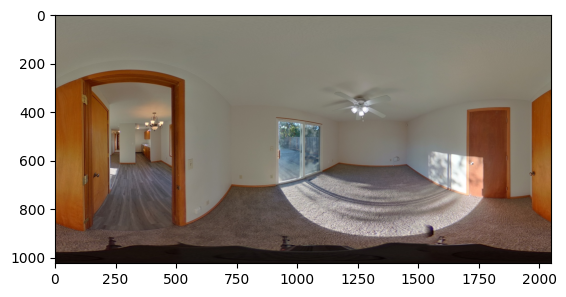

In [3]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()
image = dataset[0]["image"]

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["masks"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

print(example["masks"][0][1])
print(np.array(example["masks"]).shape)

In [9]:
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch.nn.functional as F

def pad_to_square(image):
	h, w, _ = np.array(image).shape
	diff = abs(h - w)
	padding = (0, diff, 0, 0)
	padded_image = T.functional.pad(image, padding, fill=0)
	return padded_image

class SAMDataset(Dataset):
	def __init__(self, dataset, processor):
		self.dataset = dataset
		self.processor = processor

	def __len__(self):
		return len(self.dataset)

	def __getitem__(self, idx):
		item = self.dataset[idx]
		image = item["image"]
		ground_truth_mask = item["masks"]
		padded_image = pad_to_square(image)

		mask_tensor = torch.tensor(ground_truth_mask)
  
		mask_padded = F.pad(mask_tensor, (0, 0, 1024, 0), mode="constant", value=0).unsqueeze(1).float()
  
		mask_resized = F.interpolate(
			mask_padded,
   		size = (1024, 1024),
     	mode = "nearest"
		)
	
		mask_resized = mask_resized.squeeze(1).long()
	
		mask_resized_list = mask_resized.squeeze(0).tolist()
  
		# get bounding box prompt
		prompt = item["bboxes"]

		# prepare image and prompt for the model
		inputs = self.processor(padded_image, input_boxes=[[prompt]], return_tensors="pt")

		# remove batch dimension which the processor adds by default
		inputs = {k:v.squeeze(0) for k,v in inputs.items()}

		# add ground truth segmentation
		inputs["ground_truth_mask"] = mask_resized_list

		return inputs

In [10]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [11]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
print(f"Input Shape: {np.array(train_dataset.dataset[0]["image"]).shape}")
print(f"Ground Truth Shape: {np.array(train_dataset[0]["ground_truth_mask"]).shape}")

In [12]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
	pixel_values = torch.stack([item['pixel_values'] for item in batch])  # Stapel die Pixelwerte
	original_sizes = torch.stack([item['original_sizes'] for item in batch])
	reshaped_input_sizes = torch.stack([item['reshaped_input_sizes'] for item in batch])
	input_boxes = torch.stack([item['input_boxes'] for item in batch])

	# Padding der ground_truth_mask
	ground_truth_masks = [torch.tensor(item['ground_truth_mask']) for item in batch]
	padded_masks = pad_sequence(ground_truth_masks, batch_first=True)  # Padding auf gleiche Länge

	return {
		'pixel_values': pixel_values,
		'original_sizes': original_sizes,
		'reshaped_input_sizes': reshaped_input_sizes,
		'input_boxes': input_boxes,
		'ground_truth_mask': padded_masks
	}


train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)


In [ ]:
for i, element in enumerate(train_dataloader.dataset):
  print(f"Element {i}: {element.keys()}")
  print(f"Größe: {[len(v) if isinstance(v, list) else v.shape for k, v in element.items()]}")
  if i > 5:
    break 

In [13]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 4, 4])
ground_truth_mask torch.Size([2, 1024, 1024])


In [14]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [20]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

optimizer = AdamW(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction="mean")
seg_loss = CrossEntropyLoss()

In [24]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
	epoch_losses = []
	for batch in train_dataloader:
	 
		# forward pass
		images, masks = batch
		inputs = processor(images=images, masks=masks, return_tensors="pt")
		outputs = model(**inputs)
		# outputs = model(pixel_values=batch["pixel_values"].to(device),
		# 								input_boxes=batch["input_boxes"].to(device),
		# 								multimask_output=False)

		# compute loss
		# predicted_masks = outputs.pred_masks.squeeze(1)
		# ground_truth_masks = batch["ground_truth_mask"].float().to(device)
	
		
		# loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
		loss = seg_loss(outputs.logits, masks)

		# backward pass (compute gradients of parameters w.r.t. loss)
		optimizer.zero_grad()
		loss.backward()

		# optimize
		optimizer.step()
		epoch_losses.append(loss.item())

	print(f'EPOCH: {epoch}')
	print(f'Mean loss: {mean(epoch_losses)}')

RuntimeError: The size of tensor a (2) must match the size of tensor b (1024) at non-singleton dimension 1